In [1]:
%load_ext autoreload
%autoreload 2
from models.ddm_ll import Lap_Pyramid_Conv
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
from torchvision.transforms.functional import to_pil_image

In [21]:
img = cv2.imread("/datasata/xuronghao/coding/imgs/262A3283.png")
img = torch.from_numpy((img / 255.0).transpose(2, 0, 1).astype(np.float32)).unsqueeze(0)

In [ ]:
x = torch.randn(1, 3, 256, 256).to(torch.device('cuda:1'))

In [22]:
lpm = Lap_Pyramid_Conv(2, in_chans=3)

In [23]:
out = lpm.pyramid_decom(img)

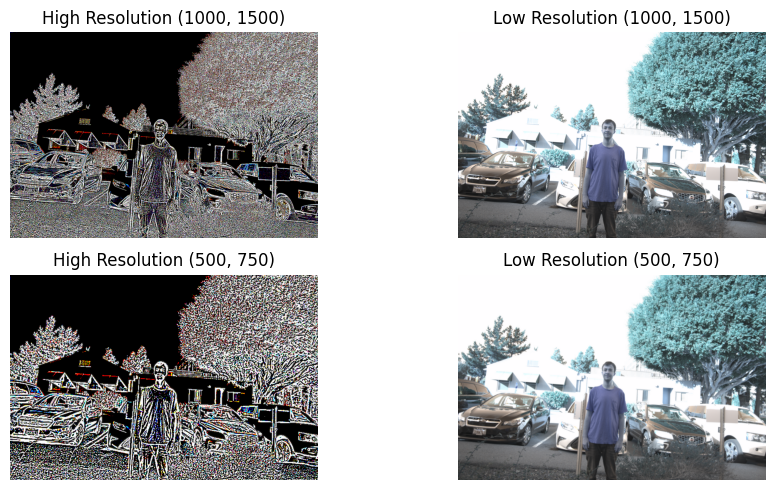

In [31]:
fig, axes = plt.subplots(len(out), 2, figsize=(10, 5))  # 创建 1 行 2 列的子图
for i in range(len(out)):
    # Step 1: 提取 high_tensor 和 low_tensor，并去掉 batch 维度
    high_tensor = out[i][0].squeeze(0)  # 形状变为 [3, H, W]
    low_tensor = out[i][1].squeeze(0)   # 形状变为 [3, H, W]

    # Step 2: 检查值范围并归一化到 [0, 1]
    if high_tensor.max() > 1:
        high_tensor = high_tensor / 255.0
    if low_tensor.max() > 1:
        low_tensor = low_tensor / 255.0

    # Step 3: 将 Tensor 转换为 PIL 图像
    high_image = to_pil_image(high_tensor)
    low_image = to_pil_image(low_tensor)

    # Step 4: 使用 matplotlib 显示 high 和 low 图像
    axes[i][0].imshow(high_image)
    axes[i][0].set_title(f"High Resolution {high_tensor.shape[1], high_tensor.shape[2]}")
    axes[i][0].axis('off')  # 关闭坐标轴

    axes[i][1].imshow(low_image)
    axes[i][1].set_title(f"Low Resolution {high_tensor.shape[1], high_tensor.shape[2]}")
    axes[i][1].axis('off')  # 关闭坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()